# Testing H-MDS Implementation

## Python/Numpy Implementation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import check_random_state
import time
from sklearn.decomposition import PCA
# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

In [5]:
def generate_data(n):
    theta = np.random.uniform(0, 2*np.pi, n)
    u = np.random.uniform(0, 0.7, n)
    r = np.sqrt(u)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    init_data = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
    return init_data

In [219]:
from sklearn.metrics import euclidean_distances

def norm(x, axis=None):
    return np.linalg.norm(x, axis=axis)

def poincare_dist(u, v, eps=1e-3):
    d = 1 + 2 * norm(u-v)**2 / ((1 - norm(u)**2) * (1 - norm(v)**2) + eps)
    return np.arccosh(d)

def partial_d(theta, x, eps=1e-3):
    alpha = 1 - norm(theta)**2
    beta = 1 - norm(x)**2
    gamma = 1 + 2/(alpha*beta + eps) * norm(theta-x)**2
    lhs = 4 / (beta*np.sqrt(gamma**2 - 1) + eps)
    rhs = 1/(alpha**2 + eps) * (norm(x)**2 - 2*np.inner(theta,x) + 1) * theta - x/(alpha + eps)
    return lhs*rhs

## Mobius transformations

We can define the Poincare disk based on the complex plane: $\mathbb{D}=\{z \in \mathbb{C}| | z |<1\}$. We have the symmetric distance function for $\boldsymbol{u}, \boldsymbol{v} \in \mathcal{D}$:

$$
d(\boldsymbol{u}, \boldsymbol{v})=\operatorname{arcosh}\left(1+2 \frac{\|\boldsymbol{u}-\boldsymbol{v}\|^{2}}{\left(1-\|\boldsymbol{u}\|^{2}\right)\left(1-\|\boldsymbol{v}\|^{2}\right)}\right)
$$ <br>
or considering the complex plane: <br>
$$
d_{\mathbb{D}}\left(z_{j}, z_{k}\right)=2 \operatorname{atanh} \frac{\left|z_{j}-z_{k}\right|}{\left|1-z_{j} \overline{z}_{k}\right|}
$$

The idea of Mobius transformations will also be important, and these are transformations that preserve hyperbolic distances. The Mobius transformations $T$ have the following form: <br> 
<br>
$$
T(z)=\frac{a z+b}{\overline{b} z+\overline{a}}, a, b \in \mathbb{C},|a|^{2}-|b|^{2} \neq 0
$$ <br>
alternatively we can write this as: <br>
$$
z^{\prime}=T(z ; c, \theta)=\frac{\theta z+c}{\overline{c} \theta z+1}, \quad|\theta|=1,|c|<1
$$

Our h-MDS algorithm will have a relatively simple design based on iterative steepest descent and an approximate line search function. Therefore, we need to be able to describe hyperbolic lines based on a given direction $\gamma$ and a starting point $z_0$. For $z_{0} \in \mathbb{D}, \gamma \in \mathbb{C}$ with $|\gamma|=1,$ and $s \geq 0$, this hyperbolic line is given by:<br>
<br>
$$
z_{0}^{\prime}=\frac{\gamma \tanh \frac{s}{2}+z_{0}}{\overline{z_{0}} \gamma \tanh \frac{s}{2}+1}
$$ <br>
where $s$ gives the length along the line and $d_{\mathrm{D}}\left(z_{0}, z_{0}^{\prime}\right)=s$

We explore mobius transformations and these hyperbolic lines in the poincaré disk.

In [211]:
# convert array or list [a, b] to complex number a+bi
def to_complex(xi):
    return np.complex(xi[0], xi[1])
to_complex([1,1])
np.complex(1+1j)*np.complex(1-1j)
np.conj(1+1j)
np.complex(1,1)
norm(np.complex(0.7,0.7))

(1+1j)

(2+0j)

(1-1j)

(1+1j)

0.9899494936611665

In [216]:
# alternate poincare distance formula with complex numbers
def pdist2(zi, zj):
    if not isinstance(zi,complex):
        zi = to_complex(zi)
    if not isinstance(zj,complex):
        zj = to_complex(zj)
    return 2*np.arctanh(norm(zi - zj) / norm(1 - zi*np.conj(zj)))

# parametrized hyperbolic line with distance s from point z0 in direction gamma
def hyp_line(s, gamma, z0):
    if not isinstance(z0,complex):
        z0 = to_complex(z0)
    if not isinstance(y,complex):
        gamma = to_complex(gamma)
    return (gamma * np.tanh(s/2) + z0) / (np.conj(z0) * gamma * np.tanh(s/2) + 1)

def plot_hyp_line(s, gamma, z0, z0_label="Zo'"):
    gamma = gamma / norm(gamma)
    pts = []
    for r in np.arange(0, s, 0.1):
        zj = hyp_line(r, gamma, z0)
        pts.append(zj)
        zj_flip = hyp_line(r, -1*gamma, z0)
        pts.append(zj_flip)
    pts = np.array(pts)
    z0_prime = pts[-1]
    ax = plt.gca()
    ax.scatter(np.real(pts), np.imag(pts), s=20, alpha=1)
    ax.scatter(np.real(z0), np.imag(z0), s=40, alpha=1, c='black')
    ax.text(np.real(z0)-0.1, np.imag(z0)+0.05, z0_label, size=16);
    #ax.scatter(np.real(z0_prime), np.imag(z0_prime), s=30, alpha=1)
    #ax.text(np.real(z0_prime)-0.1, np.imag(z0_prime)+0.05, "Zo'", size=14);
    #plt.show();

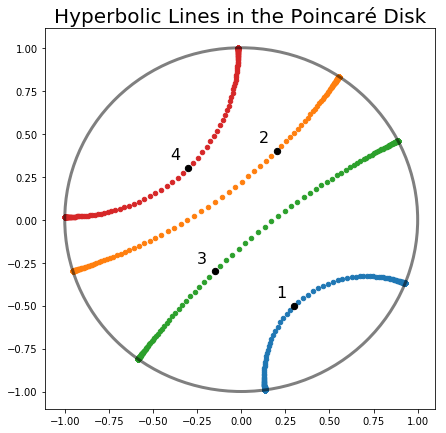

In [214]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
y = np.complex(1,1)
x = np.complex(0.8,0.2)
Z = np.array([np.complex(0.3,-0.5), np.complex(0.2,0.4), np.complex(-0.15,-0.3), np.complex(-0.3,0.3)])
for i, z0 in enumerate(Z):
    plot_hyp_line(10, y, z0, z0_label=str(i+1));
plt.title('Hyperbolic Lines in the Poincaré Disk', size=20);
plt.savefig('hyp_lines.png');

## Loss function and Gradients

In [239]:
# alternate poincare distance formula with complex numbers
def poincare_dist(zi, zj):
    if not isinstance(zi,complex):
        zi = to_complex(zi)
    if not isinstance(zj,complex):
        zj = to_complex(zj)
    return 2*np.arctanh(norm(zi - zj) / norm(1 - zi*np.conj(zj)))

def partial_d(xi, xj):
    if not isinstance(xi,complex):
        xi = to_complex(xi)
    if not isinstance(xj,complex):
        xj = to_complex(xj)
    v1 = np.real(xi) - np.real(xj)
    v2 = np.imag(xi) - np.imag(xj)
    v3 = np.real(xi)*np.real(xj) + np.imag(xi)*np.imag(xj) - 1
    v4 = np.real(xi)*np.imag(xj) - np.real(xj)*np.imag(xi)
    t = np.sqrt((v1**2 + v2**2) / (v3**2 + v4**2))
    dxi_1 = 2*t / (1 - t**2) * (v1 / (v1**2 + v2**2) - (np.real(xj)*v3 + np.imag(xj)*v4) / (v3**2 + v4**2))
    dxi_2 = 2*t / (1 - t**2) * (v2 / (v1**2 + v2**2) - (np.real(xi)*v4 - np.imag(xj)*v3) / (v3**2 + v4**2))
    return np.array([dxi_1, dxi_2])
partial_d(np.complex(0.5, 0.5), np.complex(0.49, 0.49))

array([2.82842712, 2.72177616])

In [410]:
from sklearn.metrics import euclidean_distances
def init_z(n, dim=2, low=-0.1, high=0.1, complex_num = True):
    random_config = np.random.uniform(low, high, size=(n, dim))
    z_config = np.array([to_complex(x) for x in random_config])
    if complex_num:
        return z_config
    else:
        return random_config

init_config = init_z(4, complex_num=False)
z_config = np.array([to_complex(x) for x in init_config])
delta = euclidean_distances(init_config)

In [411]:
def compute_gradients(Z, dissimilarities, alpha=1):
    n = Z.shape[0]
    gradients = np.zeros((n, 2))
    for i in range(n):
        grad_zi = 0
        for j in range(i+1, n):
            dd_loss = 2*poincare_dist(Z[i], Z[j]) - 2*alpha*dissimilarities[i][j]
            dd_dist = partial_d(Z[i], Z[j])
            grad_zi += dd_loss * dd_dist
        if norm(grad_zi) > 1:
            grad_zi = grad_zi / norm(grad_zi)
        gradients[i] = grad_zi
    return gradients
init_g = compute_gradients(init_config, delta)
init_g

array([[-0.0548659 ,  0.99849373],
       [ 0.61475032, -0.36602761],
       [ 0.02590721,  0.04234023],
       [ 0.        ,  0.        ]])

In [286]:
def loss_fn(embed_config, dissimilarities, alpha=1):
    n = dissimilarities.shape[0]
    loss = 0
    for i in range(n):
        for j in range(i+1, n):
            zi_error = (poincare_dist(embed_config[i], embed_config[j]) - alpha*dissimilarities[i][j])**2
            loss += zi_error
    return loss

def proj(theta, eps=1e-2):
    if norm(theta) >= 1:
        theta = theta/norm(theta) - eps
    return theta

loss_fn(z_config, delta)
loss_fn(init_config, delta)

0.0709840398088957

0.0709840398088957

## Approximate hyperbolic line search in PD model

In [343]:
def step_error(r, Z, g, dissimilarities, n, eps=0):
    if not isinstance(Z[0], complex):
        Z = np.array([to_complex(zi) for zi in Z])
    if not isinstance(g[0], complex):
        g = np.array([to_complex(gi) for gi in g])
    M_r = []
    for j in range(n):
        M_r.append((-r*g[j] + Z[j]) / (-r*g[j] * np.conj(Z[j]) + 1 + eps))
    return loss_fn(np.array(M_r), dissimilarities, n)
step_error(0.01, z_config, -1*init_g, delta, delta.shape[0])

0.2384149726491223

In [513]:
def line_search(Z, dissimilarities, g, n, r0, rmax):
    if not isinstance(Z[0], complex):
        Z = np.array([to_complex(zi) for zi in Z])
    if not isinstance(g[0], complex):
        g = np.array([to_complex(gi) for gi in g])
    Z_norm = np.array([norm(z)**2 for z in Z])
    M_prime = g*Z_norm
    qprime_0 = np.dot(np.real(M_prime).T, np.real(g)) + np.dot(np.imag(M_prime).T, np.imag(g))
    p = 0.5
    r = r0
    q0 = step_error(0, Z, g, dissimilarities, n)
    roof_fn = lambda r: q0 + p*qprime_0*r
    rmin = 1e-10
    while r < rmax and step_error(r, Z, g, dissimilarities, n) < roof_fn(r):
        #print(r)
        #print(step_error(r, Z, g, dissimilarities, n))
        r = 2*r
    while r > rmax or step_error(r, Z, g, dissimilarities, n) > roof_fn(r):
        #print(r)
        #print(step_error(r, Z, g, dissimilarities, n))
        #if r < rmin:
        #    return 2*r
        r = r/2
    return r
line_search(z_config, delta, -1*init_g, delta.shape[0], 0.001, 0.1)

0.064

In [514]:
from sklearn.decomposition import PCA
class HyperMDS():
    
    def __init__(self, dim=2, max_iter=3, verbose=0, eps=1e-5, alpha=1,
                 random_state=None, dissimilarity="euclidean"):
        self.dim = dim
        self.dissimilarity = dissimilarity
        self.max_iter = max_iter
        self.alpha = alpha
        self.eps = eps
        self.verbose = verbose
        self.random_state = random_state
        
    def init_embed(self, low=-0.5, high=0.5, complex_num=True):
        random_config = np.random.uniform(low, high, size=(self.n, self.dim))
        c_config = np.array([to_complex(x) for x in random_config], dtype=np.complex_)
        if complex_num:
            self.embedding = c_config
        else:
            self.embedding = random_config
    
    def loss_fn(self):
        loss = 0
        for i in range(self.n):
            for j in range(i+1, self.n):
                d_ij = poincare_dist(self.embedding[i], self.embedding[j])
                delta_ij = self.alpha*self.dissimilarity_matrix[i][j]
                loss += (d_ij - delta_ij)**2
        self.loss = loss

    def compute_gradients(self):
        gradients = np.zeros((self.n, 2))
        for i in range(self.n):
            grad_zi = 0
            for j in range(i+1, self.n):
                dd_ij = 2*poincare_dist(self.embedding[i], self.embedding[j])
                ddelta_ij = 2*self.alpha*self.dissimilarity_matrix[i][j]
                dd_loss = dd_ij - ddelta_ij
                dd_dist = partial_d(self.embedding[i], self.embedding[j])
                grad_zi += dd_loss * dd_dist
            if norm(grad_zi) > 1:
                grad_zi = grad_zi / norm(grad_zi)
            gradients[i] = grad_zi
        self.gradients = gradients
    
    def fit(self, X, init=None):
        """
        Uses gradient descent to find the embedding configuration in the Poincaré disk
        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            Input data. If ``dissimilarity=='precomputed'``, the input should
            be the dissimilarity matrix.
        init: initial configuration of the embedding coordinates
        """
        self.fit_transform(X, init=init)
        return self

    def fit_transform(self, X, init=None, max_epochs = 40, verbose=False):
        """
        Fit the embedding from X, and return the embedding coordinates
        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            Input data. If ``dissimilarity=='precomputed'``, the input should
            be the dissimilarity matrix.
        init: initial configuration of the embedding coordinates
        """
        if self.dissimilarity == "precomputed":
            self.dissimilarity_matrix = X
        elif self.dissimilarity == "euclidean":
            self.dissimilarity_matrix = euclidean_distances(X)
        self.n = self.dissimilarity_matrix.shape[0]
        
        if init == 'pca':
            pca = PCA(n_components=2)
            X_proj = pca.fit_transform(X)
            X_proj = X_proj / norm(X_proj)
            self.embedding = X_proj
        else:
            self.init_embed()
        
        smax = 2
        prev_loss = np.inf
        self.loss_fn()
        print('Inital loss: ', self.loss)
        for i in range(max_epochs):
            self.loss_fn()
            # break if loss decrease < tolerance
            #if np.abs(self.loss - prev_loss)/self.loss < 0.0001:
            #    print('loss decrease not sufficient')
            #    break
            #prev_loss = self.loss
            self.compute_gradients()
            # set max step size
            rmax = 1/(np.linalg.norm(self.gradients, np.inf).max()+self.eps) * np.tanh(smax/2)
            # perform line search
            r = line_search(self.embedding, self.dissimilarity_matrix, -1*self.gradients,
                            self.n, 0.001, rmax)
            # update each zi
            for j in range(self.n):
                zi_num = -r*to_complex(self.gradients[j]) + self.embedding[j]
                zi_denom = -r*to_complex(self.gradients[j]) * np.conj(self.embedding[j]) + 1
                zi_prime = zi_num / zi_denom
                self.embedding[j] = zi_prime
            if verbose:
                print('Epoch ' +str(i+1) + ' complete')
                print('Loss: ', self.loss)
        print('Final loss: ', self.loss)
        return self.embedding

In [457]:
# compute poincaré distance matrix
def pd_matrix(embedding):
    n = embedding.shape[0]
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist_matrix[i][j] = poincare_dist(embedding[i], embedding[j])
    return dist_matrix

# compute Sammon stress of the embedding
def sammon_stress(embedding, dissimilarity_matrix, alpha=1):
    stress = 0
    scale = 0
    n = embedding.shape[0]
    for i in range(n):
        for j in range(i+1, n):
            d_ij = poincare_dist(embedding[i], embedding[j])
            delta_ij = alpha * dissimilarity_matrix[i][j]
            scale += delta_ij
            stress += (d_ij - delta_ij)**2 #/ delta_ij
    return stress/scale

In [522]:
data = generate_data(20)
hmds = HyperMDS()
emb = hmds.fit_transform(data, max_epochs=30, verbose=True)
print('Sammon Stress: ', sammon_stress(emb, hmds.dissimilarity_matrix))

Inital loss:  131.42444242841827
Epoch 1 complete
Loss:  131.42444242841827
Epoch 2 complete
Loss:  54.80582419612313
Epoch 3 complete
Loss:  103.21368507368638
Epoch 4 complete
Loss:  128.6657259425696
Epoch 5 complete
Loss:  225.2800531425544
Epoch 6 complete
Loss:  563.9562793812032
Epoch 7 complete
Loss:  1184.0812600724396
Epoch 8 complete
Loss:  1184.0812600724441
Epoch 9 complete
Loss:  1184.0812600724462
Epoch 10 complete
Loss:  1184.0812600724498
Epoch 11 complete
Loss:  1184.0812600724535
Epoch 12 complete
Loss:  1184.081260072452
Epoch 13 complete
Loss:  1184.0812600724576
Epoch 14 complete
Loss:  1184.081260072466
Epoch 15 complete
Loss:  1184.0812600724726
Epoch 16 complete
Loss:  1184.0812600724753
Epoch 17 complete
Loss:  1184.081260072474
Epoch 18 complete
Loss:  1184.08126007248
Epoch 19 complete
Loss:  1184.0812600724823
Epoch 20 complete
Loss:  1184.0812600724817
Epoch 21 complete
Loss:  1184.0812600724848
Epoch 22 complete
Loss:  1184.0812600724914
Epoch 23 complete

IndexError: too many indices for array

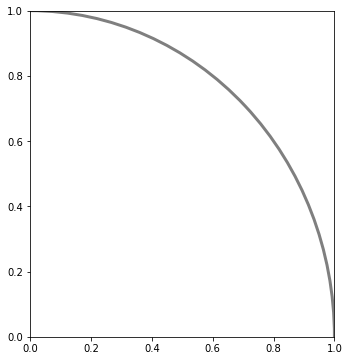

In [445]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)

x = emb[:,0]
y = emb[:,1]
ax.scatter(x, y, s=30, alpha=1)
for i in range(len(emb)):
    ax.text(x[i]+0.02, y[i]+0.02, str(i), size=14)

ax2 = fig.add_subplot(122)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax2.add_patch(circ)

x = data[:,0]
y = data[:,1]
ax2.scatter(x, y, s=30, alpha=1)
for i in range(len(data)):
    ax2.text(x[i]+0.02, y[i]+0.02, str(i), size=14);
plt.show();

In [463]:
zoo = pd.read_csv('zoo.data', header=None)
animals = ['hare', 'goat', 'octopus', 'wolf', 'chicken', 'tuna', 'lobster', 'cheetah', 
           'dove', 'opossum', 'raccoon', 'crow', 'sparrow']
animals_data = zoo.loc[zoo[0].apply(lambda x: x in animals), ]
animals_data = zoo.loc[np.random.permutation(len(zoo))[:40]]
animals_name = animals_data[0]
animals_data = animals_data.loc[:, 1:]
animals_name = np.array(animals_name)

In [468]:
hmds = HyperMDS()
animals_emb = hmds.fit_transform(animals_data, max_epochs=40, verbose=True)
sammon_stress(animals_emb, hmds.dissimilarity_matrix)

Inital loss:  9976.184605934686
Epoch 1 complete
Loss:  9976.184605934686
Epoch 2 complete
Loss:  9976.182988584584
Epoch 3 complete
Loss:  9976.181371234547
Epoch 4 complete
Loss:  9976.179753884608
Epoch 5 complete
Loss:  9976.178136534723
Epoch 6 complete
Loss:  9976.176519184906
Epoch 7 complete
Loss:  9976.174901835162
Epoch 8 complete
Loss:  9976.173284485478
Epoch 9 complete
Loss:  9976.171667135884
Epoch 10 complete
Loss:  9976.170049786371
Epoch 11 complete
Loss:  9976.168432436893
Epoch 12 complete
Loss:  9976.166815087514
Epoch 13 complete
Loss:  9976.165197738184
Epoch 14 complete
Loss:  9976.163580388931
Epoch 15 complete
Loss:  9976.16196303974
Epoch 16 complete
Loss:  9976.160345690641
Epoch 17 complete
Loss:  9976.158728341603
Epoch 18 complete
Loss:  9976.157110992626
Epoch 19 complete
Loss:  9976.155493643728
Epoch 20 complete
Loss:  9976.153876294911
Epoch 21 complete
Loss:  9976.152258946135
Epoch 22 complete
Loss:  9976.150641597436
Epoch 23 complete
Loss:  9976.14

3.106007666587996

IndexError: too many indices for array

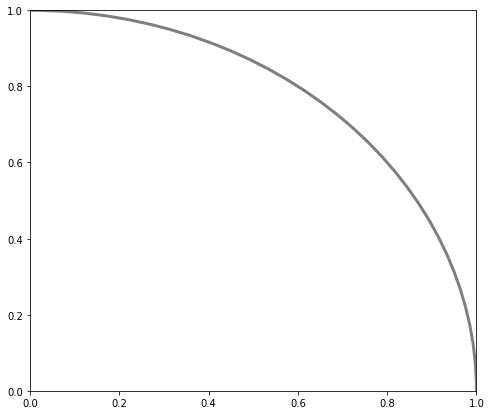

In [448]:
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)

x = animals_emb[:,0]
y = animals_emb[:,1]
ax.scatter(x, y, s=30, alpha=1)
for i in range(len(animals_emb[:40])):
    ax.text(x[i]+0.02, y[i]+0.02, animals_name[i], size=14)
plt.show();

In [449]:
from sklearn.datasets import load_iris
iris = load_iris()
iris_data = iris.data

hmds = HyperMDS(alpha=1)
iris_emb = hmds.fit_transform(iris_data, max_epochs=50, verbose=True)
sammon_stress(iris_emb, hmds.dissimilarity_matrix)

Inital loss:  53490.83146496969
Epoch 1 complete
Loss:  53490.83146496969
Epoch 2 complete
Loss:  53490.77962542928
Epoch 3 complete
Loss:  53490.72778540523
Epoch 4 complete
Loss:  53490.67594489821
Epoch 5 complete
Loss:  53490.62410390825
Epoch 6 complete
Loss:  53490.572262435235
Epoch 7 complete
Loss:  53490.52042047871
Epoch 8 complete
Loss:  53490.46857803941
Epoch 9 complete
Loss:  53490.41673511703
Epoch 10 complete
Loss:  53490.36489171145
Epoch 11 complete
Loss:  53490.313047823096
Epoch 12 complete
Loss:  53490.261203451
Epoch 13 complete
Loss:  53490.209358596265


KeyboardInterrupt: 

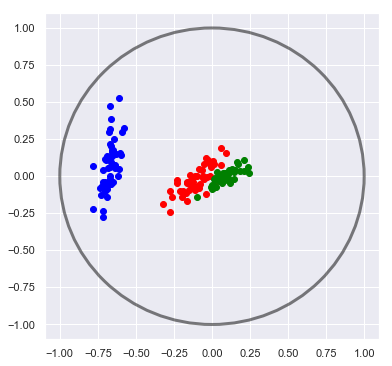

In [34]:
def plot_poincare(data, title=None):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
    ax.add_patch(circ)
    ax.scatter(data[:,0], data[:,1], s=20, alpha=1)
    if title != None: plt.title(title)
    plt.show()
y = iris.target
X = iris_emb
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
ax.scatter(X[(y==0), 0], X[(y==0), 1], c='blue')
ax.scatter(X[(y==1), 0], X[(y==1), 1], c='red');
ax.scatter(X[(y==2), 0], X[(y==2), 1], c='green');

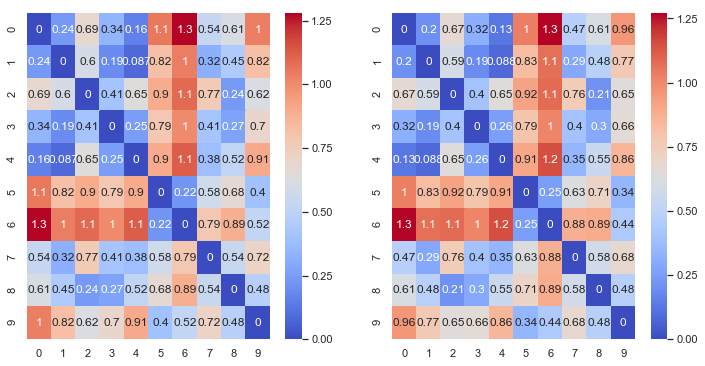

In [36]:
import seaborn as sns
n = data.shape[0]
delta1 = euclidean_distances(data)
delta2 = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        delta2[i][j] = poincare_dist(emb[i], emb[j])
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
sns.set()
sns.heatmap(delta1, cmap="coolwarm", annot=True);
ax = fig.add_subplot(122)
sns.heatmap(delta2, cmap="coolwarm", annot=True);

In [2]:
from IPython.core.display import HTML

def css_styling():
    styles = open("custom_style.css", "r").read()
    return HTML(styles)
css_styling()